# Sentence encoders: Misspellings approaches

This notebook investigates the different misspellings approaches that can be taken when using tensorflow sentence encoders on a [Kaggle essay scores](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) dataset. Varying the approaches between doing nothing, dropping misspellings and correcting misspellings shows us that dropping is likely the most effective strategy.   

Due to how long it takes the spellchecker library to correct misspellings (~ 10 seconds per essay), the dataset is limited to 900 random essays with equal score distributions. The model is then fit and evaluated on the embeddings for each approach 3 times to obtain more stable accuracy averages. 

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Limit dataset

The dataset is limited to a random selection of 900 essays with an equal score distribution. The value counts for each score are first listed. A random selection no larger than the minimum value count is then retrieved for each score.

In [2]:
# lists values counts
train.score.value_counts()

score
3    6280
2    4723
4    3926
1    1252
5     970
6     156
Name: count, dtype: int64

In [3]:
import random

# randomly selects 150 essays for each score (1-6)
random_index = []
for i in range(6):
    random_index.extend( random.sample(list(train.loc[train.score==i+1].index), 150) )

# reassigns the train dataframe to 900 essays
train = train.loc[random_index]
len(train)

900

## Preprocess text

Common preprocessing steps are applied to simplify the texts and reduce potential noise.

In [4]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)

    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lowercase the text
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

## Misspelling function

A misspelling function splits the essay into words and either drops or corrects unknown words.

In [5]:
from spellchecker import SpellChecker

# creates a spellckecker object
spell = SpellChecker()

# returns a count of misspelled words
def misspellings(essay, drop=True):

    # the essay is split into words
    words = essay.split()

    # either drops or corrects unknown words
    final_words = []
    if drop == True:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)
    
    else:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)

            else:
                # attempts to correct the word
                correction = spell.correction(word)

                # appends the correction if one was found
                if correction != None:
                    # appends to a list of words to return
                    final_words.append(correction)

    # joins the words back together with a space 
    return ' '.join(final_words)

## Model functions

The sentence encoder model is first loaded-in. A number of functions are then defined to split the essay texts in into a variable number of words, obtain the embeddings, fit a model and then record the time and accuracy results.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding
from sklearn.metrics import cohen_kappa_score

# downloads the model to obtain embeddings 
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_model = hub.load(model_url)

# returns the essay embeddings
def encode_sentences(essays):
    embeddings = encoder_model(essays)
    return embeddings.numpy()

# creates the model
def create_model(embedding_dim):
    model = Sequential([
          Input(shape=(embedding_dim,)),
          Dense(64, activation='relu'),
          Dense(32, activation='relu'),
          Dense(7, activation='softmax')
      ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# fits the model on the training data and evaluates accuracy
def fit_model(embeddings, scores, accuracy_df, approach):

    # defines how many times the model should be fit and evaluated to obain a more stable accuracy average
    turns = 3

    # stores each accuracy result in order to obtain an average
    accuracy_scores = []

    # loops through each turn
    for i in range(turns):

        # splits the data into train and validation sets
        x_train, x_val, y_train, y_val = train_test_split(embeddings, scores, test_size=0.3)
    
        # creates and embedding dimension and uses it to create a model
        embedding_dim = embeddings[0].shape[0]
        model = create_model(embedding_dim)
    
        # converts essay scores to one hot encodings
        y_train_one_hot = to_categorical(y_train)
        y_val_one_hot = to_categorical(y_val)
    
        # fits the model
        model.fit(x_train, y_train_one_hot, epochs=12, batch_size=32, validation_data=(x_val, y_val_one_hot)) 
    
        # retrieves predictions 
        predictions = model.predict(x_val)
    
        # converts raw predictions (decimals) into final predictions (1 - 6 integers)
        converted_preds = [np.argmax(pred) for pred in predictions]
        converted_y_val = [np.argmax(y) for y in y_val_one_hot]
    
        # appends rounded Cohen Kappa scores 
        accuracy_scores.append(round(cohen_kappa_score(converted_preds, converted_y_val, weights='quadratic'), 2))
    
    # adds the average accuracy score to the accuracy dataframe
    accuracy_df.loc[0, approach] = round(np.mean(accuracy_scores), 2)
    
    return accuracy_df

## Misspellings approaches

The data is prepared and each approach is carried out as part of a loop. First, the relavant misspellings approach is applied to the text. Second, the embeddings are retrieved. Third, a model is fit and evaluated 3 times to obtain a more stable average. 

In [8]:
import time as t

# creates an accuracy and time dataframe to store results
accuracy_df = pd.DataFrame()
time_df = pd.DataFrame()

# preprocesses the texts
train['full_text'] = [preprocess_text(x) for x in train['full_text']]

# converts scores to a numpy array for use in the model
scores = np.array(train['score'])

# limits each essay to the first 300 words
texts = [' '.join(x.split()[0:300]) for x in train['full_text']]

# defines the various misspellings approaches
misspelling_approaches = ['nothing', 'drop', 'correct']

# loops through each approach
for approach in misspelling_approaches:

    # records a start time for later analysis
    start_time = t.time()

    # simply obtains the embeddings
    if approach == 'nothing':
        print('Preparing embeddings: ' + approach)
        embeddings = encode_sentences(texts)

    # drops misspellings and obtains the embeddings
    elif approach == 'drop':
        print('Dropping misspellings')
        dropped_misspellings = [misspellings(x) for x in texts]
        print('Preparing embeddings: ' + approach)
        embeddings = encode_sentences(dropped_misspellings)

    # corrects misspellings and obtains the embeddings
    elif approach == 'correct':
        print('Correcting misspellings')
        corrected_misspellings = [misspellings(x, drop=False) for x in texts]
        print('Preparing embeddings: ' + approach)
        embeddings = encode_sentences(corrected_misspellings)

    # records an end time for analysis
    end_time = t.time()

    # adds the total time taken to the time_df for analysis
    time_df.loc[0, approach] = round(end_time-start_time, 2)

    # fits the model 3 times and adds the average accuracy to the accuracy_df
    print('Fitting model: ' + approach)
    accuracy_df = fit_model(embeddings, scores, accuracy_df, approach)

    # reassigns the embeddings object to nother to conserve memory
    embeddings = ''

Preparing embeddings: nothing
Fitting model: nothing
Epoch 1/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2036 - loss: 1.9284 - val_accuracy: 0.3370 - val_loss: 1.8652
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3782 - loss: 1.8192 - val_accuracy: 0.3111 - val_loss: 1.7225
Epoch 3/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3797 - loss: 1.6461 - val_accuracy: 0.3407 - val_loss: 1.5604
Epoch 4/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4141 - loss: 1.4581 - val_accuracy: 0.3185 - val_loss: 1.4371
Epoch 5/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4956 - loss: 1.3342 - val_accuracy: 0.3704 - val_loss: 1.3709
Epoch 6/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5177 - loss: 1.2488 - val_accuracy: 0.4037 - val_loss: 1.3297
Epoch 7/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5059 - loss: 1.2111 - val_accuracy: 0.4111 - val_loss: 1.3127
Epoch 8/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.

## Visualization

We can see that the time it takes to correct the essay misspellings is significantly longer and does not contribute to greater accuracy. Dropping the misspellings appears to yield slightly better results and so this should be the preffered method.

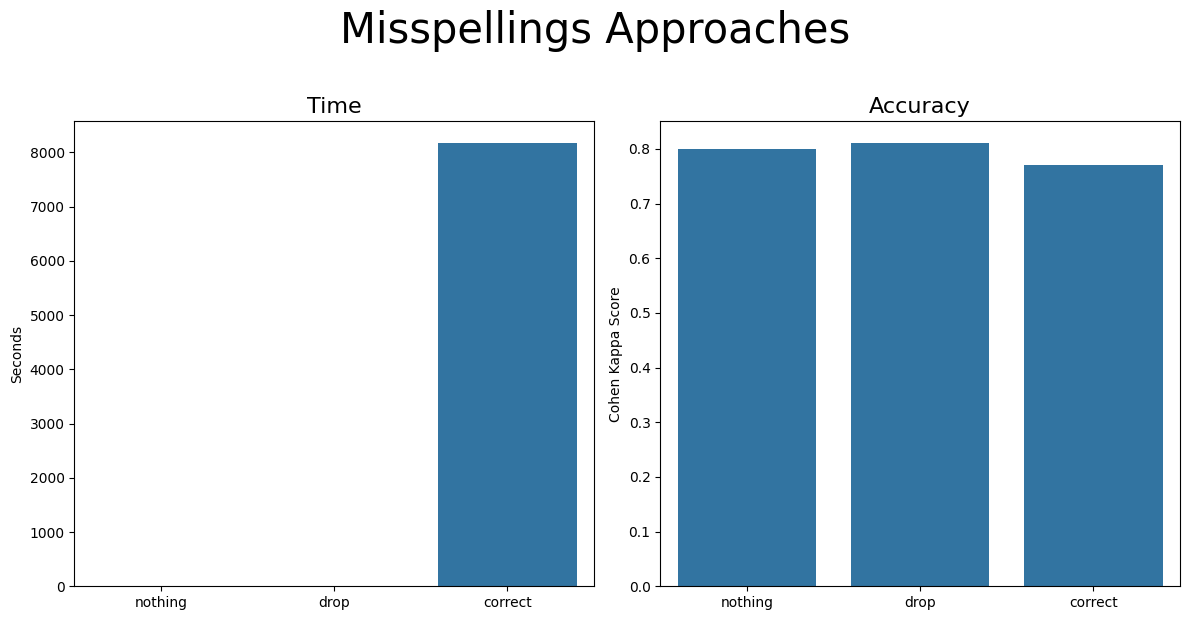

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# a single results dataframe is created 
results_df = pd.DataFrame()
results_df['time'] = time_df.transpose()
results_df['accuracy'] = accuracy_df.transpose()

# a subplots object is defined
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# different ylabels are defined 
ylabels = ['Seconds', 'Cohen Kappa Score']

# a lineplpot is created for each result type
for i, col in enumerate(results_df.columns):
    sns.barplot(x=results_df.index, y=results_df.iloc[:,i], data=results_df, ax=ax[i]);
    ax[i].set_title(results_df.iloc[:,i].name.title(), size=16);
    ax[i].set_ylabel(ylabels[i]);
    ax[i].set_xlabel('');
    
fig.suptitle('Misspellings Approaches', size=30, y=1.025)
plt.tight_layout()